## 4. Feature_Engineering

In [39]:
#Import libraries for feature engineering
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import mutual_info_regression, SelectKBest
import warnings

# Configure settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

print("🔧 FEATURE ENGINEERING SETUP")
print("=" * 35)
print("✅ Libraries imported successfully!")
print(f"📊 Pandas version: {pd.__version__}")
print(f"🤖 Scikit-learn available for feature selection")

🔧 FEATURE ENGINEERING SETUP
✅ Libraries imported successfully!
📊 Pandas version: 2.2.3
🤖 Scikit-learn available for feature selection


In [40]:
#Load cleaned data (from data processing step)
df = pd.read_csv('../data/processed/prepocessed_daily_data.csv')  # Will be updated to use processed data
df.set_index('datetime', inplace=True)
df.index = pd.to_datetime(df.index)

In [41]:
df.drop(columns=['feelslikemax', 'feelslikemin', 'feelslike', 'is_rainy'], inplace=True)

In [42]:
df['sunrise'] = pd.to_datetime(df['sunrise'])
df['sunset'] = pd.to_datetime(df['sunset'])
df['day_length_hours'] = df['sunset'] - df['sunrise']
df = df.drop(columns=['sunrise', 'sunset'])
df['day_length_hours'] = df['day_length_hours'].dt.total_seconds() / 3600.0

df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
df['dayofyear_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365)
df['dayofyear_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365)

df.drop(columns=['day', 'month', 'day_of_year'], inplace=True)

df['target5+'] = df['temp'].shift(-5)
df['target4+'] = df['temp'].shift(-4)
df['target3+'] = df['temp'].shift(-3)
df['target2+'] = df['temp'].shift(-2)
df['target1+'] = df['temp'].shift(-1)
df = df[~df['target5+'].isna()].copy()

In [43]:
df["temp_solar_interaction"] = df["temp"] * df["solarradiation"]
df["uv_temp_interaction"] = df["uvindex"] * df["temp"]
df['temp_cloudcover_interaction'] = df['temp'] * df['cloudcover']
df['temp_sealevelpressure_interaction'] = df['temp'] * df['sealevelpressure']
df['weighted_precip'] = df['precipprob'] * df['precip']

In [44]:
# Tạo feature winddir_sin
df['winddir_sin'] = np.sin(2 * np.pi * df['winddir'] / 360)
# Tạo feature winddir_cos
df['winddir_cos'] = np.cos(2 * np.pi * df['winddir'] / 360)
# (Tùy chọn) Bỏ cột winddir gốc
df = df.drop('winddir', axis=1)

# Tạo feature moonphase_sin
df['moonphase_sin'] = np.sin(2 * np.pi * df['moonphase'] / 1)

# Tạo feature moonphase_cos
df['moonphase_cos'] = np.cos(2 * np.pi * df['moonphase'] / 1)

# (Tùy chọn) Bỏ cột moonphase gốc
df = df.drop('moonphase', axis=1)

In [45]:
# Create lagging features
def create_lag_features(df, cols, lags):
    for col in cols:
        for lag in lags:
            df[f"{col}_lag_{lag}"] = df[col].shift(lag)
    return df

# Specify columns and lags
# Get all numerical columns
computing_columns = df.drop(columns=['year', 'season', 'target5+', 'target4+', 'target3+', 'target2+', 'target1+' ]).columns

lag_steps = [1, 2, 3, 5, 7, 10, 14]  # Example lag steps

# Apply lagging features before handling rolling horizons
df = create_lag_features(df, computing_columns, lag_steps)

# Function to compute rolling mean and percentage change
def compute_rolling(df, horizon, col):
    label = f"rolling_{horizon}_{col}"
    df[label] = df[col].rolling(horizon, min_periods=horizon).mean()  # Ensure full horizon is used
    df[f"{label}_change"] = df[col] - df[label]
    return df

# Compute rolling features for specified horizons
rolling_horizons = [3, 7, 14]  # Rolling windows of 3, 7, 14 days
for horizon in rolling_horizons:
    for col in computing_columns:
        df = compute_rolling(df, horizon, col)

In [46]:
#Months and days average
def expand_mean(df):
    return df.expanding(1).mean()

for col in computing_columns:
    df[f"month_avg_{col}"] = df[col].groupby(df.index.month, group_keys=False).apply(expand_mean)
    df[f"day_avg_{col}"] = df[col].groupby(df.index.day_of_year, group_keys=False).apply(expand_mean)
    df[f"year_avg_{col}"] = df[col].groupby(df.index.year, group_keys=False).apply(expand_mean)
    df[f"season_avg_{col}"] = df[col].groupby(df['season'], group_keys=False).apply(expand_mean)
    df["month_max_temp"] = df['temp'].groupby(df.index.month, group_keys=False).cummax()
    df["month_min_temp"] = df['temp'].groupby(df.index.month, group_keys=False).cummin()

df["temp_volatility_7"] = df["temp"].rolling(7).std()
df["temp_volatility_14"] = df["temp"].rolling(14).std()
df["temp_spike_flag"] = (df["temp"] - df["temp"].shift(1)).abs() > 5
df["temp_anomaly_vs_month_avg"] = df["temp"] - df["month_avg_temp"]
df["temp_anomaly_vs_season_avg"] = df["temp"] - df["season_avg_temp"]

df["pressure_trend_3d"] = df["sealevelpressure"] - df["sealevelpressure"].shift(3)
df["pressure_trend_7d"] = df["sealevelpressure"] - df["sealevelpressure"].shift(7)

In [47]:
# Drop rows with NaN values caused by rolling horizons
df = df.iloc[14:]
# Verify no NaN values exist
nan_summary = df.isna().sum()
print("Summary of NaN values in each column after handling rolling horizons and lagging:")
print(nan_summary[nan_summary > 0])

if df.isna().any().any():
    print("\nThe dataframe contains NaN values.")
else:
    print("\nThe dataframe does not contain any NaN values.")

Summary of NaN values in each column after handling rolling horizons and lagging:
Series([], dtype: int64)

The dataframe does not contain any NaN values.


In [48]:
df.shape

(3635, 574)

In [49]:
df.to_csv('../data/processed/feature_engineering_daily_data2.csv')

## 5. Model Training

In [9]:
# =============================================================================
#  CORE LIBRARIES
# =============================================================================
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

# =============================================================================
#  SCIKIT-LEARN: Preprocessing, Feature Selection, Pipeline, CV, Metrics
# =============================================================================
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
from sklearn.impute import SimpleImputer
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.inspection import permutation_importance

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ----------------------------------------------------------------------
#  Models: Base Regressors
# ----------------------------------------------------------------------
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor

# =============================================================================
#  BOOSTING LIBRARIES
# =============================================================================
import xgboost as xgb
from xgboost import XGBRegressor

import lightgbm as lgb
from lightgbm import LGBMRegressor

import catboost as cb
from catboost import CatBoostRegressor

# =============================================================================
#  HYPERPARAMETER OPTIMIZATION & UTILS
# =============================================================================
from scipy.stats import uniform, randint
import optuna
import joblib

In [4]:
#Loading processed data
df = pd.read_csv('../data/processed/feature_engineering_daily_data2.csv', index_col='datetime')

In [7]:
X = df.drop(columns=['target5+', 'target4+', 'target3+', 'target2+', 'target1+'])
y = df[['target5+', 'target4+', 'target3+', 'target2+', 'target1+']]

In [25]:
def build_preprocessing_pipeline(X):
    """Xây dựng ColumnTransformer cho tiền xử lý số và phân loại."""
    
    # Phân loại cột
    cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
    # Các cột số (loại trừ các cột nhị phân/integer mà ta muốn giữ nguyên nếu có)
    num_cols = X.select_dtypes(include=[np.number]).columns.tolist()

    print(f"Numerical Features ({len(num_cols)}): {num_cols}")
    print(f"Categorical Features ({len(cat_cols)}): {cat_cols}")
    print("-" * 40)

    # Sub-pipeline cho các biến số (Impute bằng trung vị, sau đó Scale)
    numerical_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    # Sub-pipeline cho các biến phân loại (Impute bằng hằng số, sau đó One-Hot Encode)
    categorical_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    # ColumnTransformer kết hợp hai sub-pipeline
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_pipeline, num_cols),
            ('cat', categorical_pipeline, cat_cols)
        ],
        remainder='passthrough', # Giữ lại các cột không được xử lý nếu có
        verbose_feature_names_out=False
    )
    
    return preprocessor

def run_feature_selection_rf_cv(X, y, k_features=100, test_size=0.2, random_state=42):
    """
    Feature Selection dựa trên RandomForest + Permutation Importance
    HỖ TRỢ MULTI-OUTPUT (nhiều biến y)
    """
    # Chuẩn hóa y thành 2D: (n_samples, n_targets)
    if isinstance(y, (pd.Series, pd.DataFrame)):
        y_values = y.values if isinstance(y, pd.DataFrame) else y.values.reshape(-1, 1)
    else:
        y_values = y.reshape(-1, 1) if y.ndim == 1 else y

    n_targets = y_values.shape[1]
    target_names = y.columns.tolist() if isinstance(y, pd.DataFrame) else [f"target_{i}" for i in range(n_targets)]

    print(f"Detected {n_targets} target(s): {target_names}")
    print(f"Using simple train/test split ({1-test_size:.0%}/{test_size:.0%})")
    print("="*80)

    # Chia dữ liệu
    split_idx = int(len(X) * (1 - test_size))
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y_values[:split_idx], y_values[split_idx:]

    # Preprocessing
    preprocessor = build_preprocessing_pipeline(X)
    X_train_p = preprocessor.fit_transform(X_train)
    X_test_p = preprocessor.transform(X_test)
    feature_names = preprocessor.get_feature_names_out()

    # Mô hình: MultiOutput nếu cần
    base_rf = RandomForestRegressor(
        n_estimators=300,
        max_depth=None,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=random_state,
        n_jobs=-1
    )
    rf = MultiOutputRegressor(base_rf) if n_targets > 1 else base_rf

    print("Fitting RandomForest on training set...", end=" ")
    rf.fit(X_train_p, y_train)
    print("Done.")

    # Dự đoán & tính R² cho từng target
    y_pred = rf.predict(X_test_p)
    r2_per_target = []
    for t in range(n_targets):
        r2 = r2_score(y_test[:, t], y_pred[:, t])
        r2_per_target.append(r2)
    mean_r2 = np.mean(r2_per_target)

    print(f"Mean R² on test set: {mean_r2:.4f}")
    print(f"Per-target R²: {dict(zip(target_names, np.round(r2_per_target, 4)))}")
    print("-"*80)

    # Permutation Importance cho từng target
    print("Computing Permutation Importance for each target...")
    perm_importances_per_target = []

    for t in range(n_targets):
        print(f"  Target {t+1}/{n_targets}: {target_names[t]}...", end=" ")
        estimator_t = rf.estimators_[t] if n_targets > 1 else rf
        y_test_t = y_test[:, t]

        perm = permutation_importance(
            estimator_t,
            X_test_p,
            y_test_t,
            n_repeats=10,
            random_state=random_state,
            n_jobs=-1,
            scoring='r2'
        )
        perm_importances_per_target.append(perm.importances_mean)
        print(f"Done.")
    
    perm_importances_per_target = np.array(perm_importances_per_target)  # (n_targets, n_features)

    # Tổng hợp: trung bình importance qua các target
    mean_importance = perm_importances_per_target.mean(axis=0)  # (n_features,)
    std_importance = perm_importances_per_target.std(axis=0)

    print("="*80)
    print(f"TOP {k_features} FEATURES (Averaged Permutation Importance across {n_targets} targets)")
    print("="*80)

    # Sắp xếp và chọn top k
    sorted_idx = mean_importance.argsort()[::-1]
    top_k_idx = sorted_idx[:k_features]
    top_k_features = [feature_names[i] for i in top_k_idx]

    # Hiển thị top 20
    for i, idx in enumerate(top_k_idx[:20], 1):
        name = feature_names[idx]
        imp = mean_importance[idx]
        std = std_importance[idx]
        print(f"  {i:2d}. {name:<50} {imp:+.6f} (±{std:.4f})")

    print(f"\nSelected {len(top_k_features)} features for final model.")
    print("="*80)

    return {
        'top_features': top_k_features,
        'importance_mean': mean_importance,
        'importance_per_target': perm_importances_per_target,
        'importance_std': std_importance,
        'feature_names': feature_names,
        'r2_per_target': r2_per_target,
        'r2_mean': mean_r2,
        'X_test': X_test_p,
        'y_test': y_test,
        'y_pred': y_pred
    }, preprocessor

In [26]:
selection_result, preprocessor = run_feature_selection_rf_cv(
    X, y, k_features=100, test_size=0.2, random_state=42
)

# Lấy top features
top_features = selection_result['top_features']

# Dùng để transform dữ liệu cuối cùng
X_selected = pd.DataFrame(
    preprocessor.transform(X),
    columns=preprocessor.get_feature_names_out()
)[top_features]

Detected 5 target(s): ['target5+', 'target4+', 'target3+', 'target2+', 'target1+']
Using simple train/test split (80%/20%)
Numerical Features (567): ['tempmax', 'tempmin', 'temp', 'dew', 'humidity', 'precip', 'precipprob', 'precipcover', 'windgust', 'windspeed', 'sealevelpressure', 'cloudcover', 'visibility', 'solarradiation', 'solarenergy', 'uvindex', 'year', 'temp_range', 'day_length_hours', 'month_sin', 'month_cos', 'dayofyear_sin', 'dayofyear_cos', 'temp_solar_interaction', 'uv_temp_interaction', 'temp_cloudcover_interaction', 'temp_sealevelpressure_interaction', 'weighted_precip', 'winddir_sin', 'winddir_cos', 'moonphase_sin', 'moonphase_cos', 'tempmax_lag_1', 'tempmax_lag_2', 'tempmax_lag_3', 'tempmax_lag_5', 'tempmax_lag_7', 'tempmax_lag_10', 'tempmax_lag_14', 'tempmin_lag_1', 'tempmin_lag_2', 'tempmin_lag_3', 'tempmin_lag_5', 'tempmin_lag_7', 'tempmin_lag_10', 'tempmin_lag_14', 'temp_lag_1', 'temp_lag_2', 'temp_lag_3', 'temp_lag_5', 'temp_lag_7', 'temp_lag_10', 'temp_lag_14', '

In [27]:
def benchmark_models_with_top_features(
    X, y, top_features, val_ratio=0.25, test_ratio=0.2, random_state=None, plot=True
):
    """
    Đánh giá nhiều mô hình trên top features.
    - HỖ TRỢ MULTI-OUTPUT (y có nhiều cột)
    - CHIA DỮ LIỆU CỐ ĐỊNH: 60% train / 20% val / 20% test
    - TỰ ĐỘNG XỬ LÝ ĐỊNH DẠNG y CHO TỪNG MODEL
    """
    # === 1. Lấy dữ liệu đã chọn ===
    X_selected = X[top_features].copy()
    
    # Chuẩn hóa y thành DataFrame
    if isinstance(y, (pd.Series, np.ndarray)):
        y = pd.DataFrame(y)
    elif isinstance(y, pd.DataFrame):
        y = y.copy()
    else:
        raise ValueError("y must be DataFrame, Series, or numpy array")
    
    # Đặt tên cột nếu chưa có
    if y.shape[1] == 1:
        y.columns = ['target']
    else:
        y.columns = [f"target_{i}" if col.startswith('Unnamed') or col != f"target_{i}" else col 
                     for i, col in enumerate(y.columns)]
    
    n_samples = len(X_selected)
    n_outputs = y.shape[1]
    target_names = y.columns.tolist()

    # === 2. Chia dữ liệu cố định ===
    test_idx = int(n_samples * (1 - test_ratio))
    train_val_idx = int(test_idx * (1 - val_ratio / (1 - test_ratio)))
    
    X_train = X_selected.iloc[:train_val_idx].copy()
    X_val = X_selected.iloc[train_val_idx:test_idx].copy()
    X_test = X_selected.iloc[test_idx:].copy()
    
    y_train = y.iloc[:train_val_idx].copy()
    y_val = y.iloc[train_val_idx:test_idx].copy()
    y_test = y.iloc[test_idx:].copy()
    
    X_train_val = X_selected.iloc[:test_idx].copy()
    y_train_val = y.iloc[:test_idx].copy()

    print(f"Data split (fixed order):")
    print(f" Train: {len(X_train)} | Val: {len(X_val)} | Test: {len(X_test)}")
    print(f" Targets ({n_outputs}): {target_names}")
    print(f" Features: {len(top_features)}")
    print("="*80)

    # === 3. Hàm fit/predict an toàn ===
    def safe_fit_predict(model, X_tr, y_tr, X_v, is_native_multioutput=False):
        if n_outputs == 1:
            model.fit(X_tr, y_tr.iloc[:, 0])
            pred = model.predict(X_v)
            return pred.reshape(-1, 1)  # Luôn trả về 2D
        else:
            if is_native_multioutput:
                model.fit(X_tr, y_tr.values)
                return model.predict(X_v)  # Đã là 2D
            else:
                multi_model = MultiOutputRegressor(model)
                multi_model.fit(X_tr, y_tr)
                return multi_model.predict(X_v)

    # === 4. Danh sách mô hình ===
    base_models = {
        'Linear': (LinearRegression(), False),
        'Ridge': (Ridge(alpha=1.0), False),
        'Lasso': (Lasso(alpha=0.1, max_iter=10000), False),
        'Random Forest': (RandomForestRegressor(
            n_estimators=300, max_depth=15, min_samples_split=5,
            min_samples_leaf=2, random_state=42, n_jobs=-1
        ), True),
        'XGBoost': (xgb.XGBRegressor(
            n_estimators=300, max_depth=8, learning_rate=0.1,
            subsample=0.8, colsample_bytree=0.8, random_state=42, verbosity=0
        ), True),
        'LightGBM': (lgb.LGBMRegressor(
            n_estimators=300, max_depth=8, learning_rate=0.1,
            subsample=0.8, colsample_bytree=0.8, random_state=42, verbose=-1
        ), False),  # LightGBM KHÔNG hỗ trợ multi-output → dùng MultiOutputRegressor
        'CatBoost': (cb.CatBoostRegressor(
            n_estimators=300, 
            depth=8, 
            learning_rate=0.1,
            loss_function='MultiRMSE',   # ← THÊM DÒNG NÀY
            random_state=42, 
            verbose=False
        ), True),
        'Decision Tree': (DecisionTreeRegressor(max_depth=15, min_samples_split=5, random_state=42), False),
        'KNN': (KNeighborsRegressor(n_neighbors=5, weights='distance'), False),
        'SVR': (SVR(kernel='rbf', C=10, gamma='scale', epsilon=0.1), False)
    }

    # === 5. Huấn luyện & đánh giá ===
    results = {}
    for name, (base_model, native_multi) in base_models.items():
        print(f"Training {name}...", end=" ")
        try:
            y_pred_val = safe_fit_predict(base_model, X_train, y_train, X_val, native_multi)
            # Đảm bảo y_pred_val là 2D
            if y_pred_val.ndim == 1:
                y_pred_val = y_pred_val.reshape(-1, 1)
            
            r2_list = [r2_score(y_val.iloc[:, i], y_pred_val[:, i]) for i in range(n_outputs)]
            r2_mean = np.mean(r2_list)
            mae = mean_absolute_error(y_val, y_pred_val)
            rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
            
            results[name] = {
                'R2_mean': r2_mean,
                'R2_per_target': r2_list,
                'MAE': mae,
                'RMSE': rmse,
                'base_model': base_model,
                'native_multi': native_multi
            }
            print(f"R²: {r2_mean:.4f} | MAE: {mae:.4f} | RMSE: {rmse:.4f}")
        except Exception as e:
            print(f"FAILED: {e}")
            results[name] = {'R2_mean': -np.inf, 'MAE': np.inf, 'RMSE': np.inf}

    # === 6. Bảng xếp hạng ===
    df_results = pd.DataFrame({
        'Model': [k for k in results.keys() if results[k]['R2_mean'] != -np.inf],
        'R2_mean': [r['R2_mean'] for r in results.values() if r['R2_mean'] != -np.inf],
        'MAE': [r['MAE'] for r in results.values() if r['MAE'] != np.inf],
        'RMSE': [r['RMSE'] for r in results.values() if r['RMSE'] != np.inf]
    }).round(4).sort_values('R2_mean', ascending=False).reset_index(drop=True)

    print("\n" + "="*80)
    print("RANKING ON VALIDATION SET")
    print("="*80)
    print(df_results.to_string(index=True))

    # === 7. Best model + retrain ===
    if len(df_results) == 0:
        raise ValueError("All models failed!")
        
    best_name = df_results.iloc[0]['Model']
    best_base_model = results[best_name]['base_model']
    native_multi = results[best_name]['native_multi']
    
    print(f"\nBEST MODEL: {best_name} → Retraining on train+val...")
    y_pred_test = safe_fit_predict(best_base_model, X_train_val, y_train_val, X_test, native_multi)
    if y_pred_test.ndim == 1:
        y_pred_test = y_pred_test.reshape(-1, 1)

    # === 8. Test metrics ===
    test_r2_list = [r2_score(y_test.iloc[:, i], y_pred_test[:, i]) for i in range(n_outputs)]
    test_mae_list = [mean_absolute_error(y_test.iloc[:, i], y_pred_test[:, i]) for i in range(n_outputs)]
    test_rmse_list = [np.sqrt(mean_squared_error(y_test.iloc[:, i], y_pred_test[:, i])) for i in range(n_outputs)]
    
    test_r2 = np.mean(test_r2_list)
    test_mae = np.mean(test_mae_list)
    test_rmse = np.mean(test_rmse_list)

    print(f"HOLD-OUT TEST → Mean R²: {test_r2:.4f} | Mean MAE: {test_mae:.4f} | Mean RMSE: {test_rmse:.4f}")
    print("\nPer-target performance on TEST set:")
    per_target_df = pd.DataFrame({
        'Target': target_names,
        'R2': [f"{r:.4f}" for r in test_r2_list],
        'MAE': [f"{m:.4f}" for m in test_mae_list],
        'RMSE': [f"{rm:.4f}" for rm in test_rmse_list]
    })
    print(per_target_df.to_string(index=False))

    # === 9. Vẽ biểu đồ ===
    if plot and len(df_results) > 0:
        plt.figure(figsize=(10, 6))
        sns.barplot(data=df_results, x='R2_mean', y='Model', palette='viridis')
        plt.title('Model Performance (Mean R²)')
        plt.xlabel('R² Score')
        plt.ylabel('Model')
        plt.xlim(0, 1)
        plt.tight_layout()
        plt.show()

    # === 10. Tạo best_model đã train đầy đủ ===
    if n_outputs == 1:
        best_model = best_base_model
        best_model.fit(X_train_val, y_train_val.iloc[:, 0])
    else:
        if native_multi:
            best_model = best_base_model
            best_model.fit(X_train_val, y_train_val.values)
        else:
            best_model = MultiOutputRegressor(best_base_model)
            best_model.fit(X_train_val, y_train_val)

    # === 11. Trả về ===
    return {
        'results_df': df_results,
        'best_model_name': best_name,
        'best_model': best_model,
        'test_metrics': {
            'R2_mean': test_r2,
            'R2_per_target': test_r2_list,
            'MAE': test_mae,
            'RMSE': test_rmse
        },
        'target_names': target_names,
        'X_test': X_test,
        'y_test': y_test,
        'y_pred_test': y_pred_test
    }

Data split (fixed order):
 Train: 1999 | Val: 909 | Test: 727
 Targets (5): ['target_0', 'target_1', 'target_2', 'target_3', 'target_4']
 Features: 100
Training Linear... R²: 0.8308 | MAE: 1.6361 | RMSE: 2.0992
Training Ridge... R²: 0.8301 | MAE: 1.6407 | RMSE: 2.1037
Training Lasso... R²: 0.8253 | MAE: 1.6441 | RMSE: 2.1328
Training Random Forest... R²: 0.8101 | MAE: 1.7203 | RMSE: 2.2237
Training XGBoost... R²: 0.8090 | MAE: 1.7156 | RMSE: 2.2305
Training LightGBM... R²: 0.8039 | MAE: 1.7374 | RMSE: 2.2598
Training CatBoost... R²: 0.8087 | MAE: 1.7001 | RMSE: 2.2320
Training Decision Tree... R²: 0.6280 | MAE: 2.3582 | RMSE: 3.1124
Training KNN... R²: 0.7709 | MAE: 1.8661 | RMSE: 2.4424
Training SVR... R²: 0.7966 | MAE: 1.7734 | RMSE: 2.3013

RANKING ON VALIDATION SET
           Model  R2_mean     MAE    RMSE
0         Linear   0.8308  1.6361  2.0992
1          Ridge   0.8301  1.6407  2.1037
2          Lasso   0.8253  1.6441  2.1328
3  Random Forest   0.8101  1.7203  2.2237
4        X

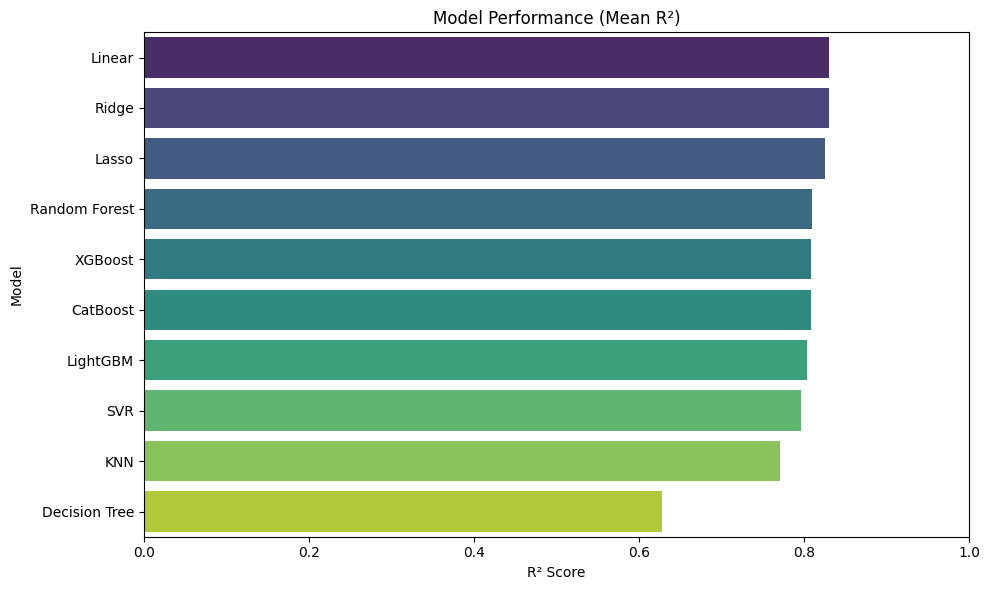

{'results_df':            Model  R2_mean     MAE    RMSE
 0         Linear   0.8308  1.6361  2.0992
 1          Ridge   0.8301  1.6407  2.1037
 2          Lasso   0.8253  1.6441  2.1328
 3  Random Forest   0.8101  1.7203  2.2237
 4        XGBoost   0.8090  1.7156  2.2305
 5       CatBoost   0.8087  1.7001  2.2320
 6       LightGBM   0.8039  1.7374  2.2598
 7            SVR   0.7966  1.7734  2.3013
 8            KNN   0.7709  1.8661  2.4424
 9  Decision Tree   0.6280  2.3582  3.1124,
 'best_model_name': 'Linear',
 'best_model': MultiOutputRegressor(estimator=LinearRegression()),
 'test_metrics': {'R2_mean': np.float64(0.8115057232357156),
  'R2_per_target': [0.7524471928027757,
   0.7666069376275803,
   0.7895855395743872,
   0.8314974815441676,
   0.9173914646296679],
  'MAE': np.float64(1.700620771742771),
  'RMSE': np.float64(2.1724686194394165)},
 'target_names': ['target_0', 'target_1', 'target_2', 'target_3', 'target_4'],
 'X_test':       dayofyear_cos_lag_14  temp_sealevelpressur

In [28]:
benchmark_models_with_top_features(X_selected, y, top_features)

## Linear Model

In [31]:
def linear_regression(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    plot=True
):
    """
    Chỉ chạy Linear Regression (hỗ trợ multi-output)
    Chia 80% train / 20% test
    In chi tiết R², MAE, RMSE cho từng target + trung bình
    """
    # === 1. Chuẩn hóa y ===
    if isinstance(y, (pd.Series, np.ndarray)):
        y_df = pd.DataFrame(y)
    else:
        y_df = y.copy()
    
    if y_df.shape[1] == 1:
        y_df.columns = ['target']
    else:
        y_df.columns = [col if not col.startswith('Unnamed') else f'target_{i}' 
                       for i, col in enumerate(y_df.columns)]
    
    target_names = y_df.columns.tolist()
    n_targets = len(target_names)
    
    print(f"Linear Regression | {n_targets} target(s): {target_names}")
    print(f"Data: {X.shape[0]:,} samples × {X.shape[1]:,} features")
    print("="*80)

    # === 2. Chia train/test ===
    split_idx = int(len(X) * (1 - test_size))
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]
    
    print(f"Train: {len(X_train):,} | Test: {len(X_test):,}")

    # === 3. Tạo model ===
    if n_targets == 1:
        model = LinearRegression()
        model.fit(X_train, y_train.iloc[:, 0])
        y_pred = model.predict(X_test).reshape(-1, 1)
    else:
        model = MultiOutputRegressor(LinearRegression())
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    # === 4. Tính metrics ===
    r2_list = [r2_score(y_test.iloc[:, i], y_pred[:, i]) for i in range(n_targets)]
    mae_list = [mean_absolute_error(y_test.iloc[:, i], y_pred[:, i]) for i in range(n_targets)]
    rmse_list = [np.sqrt(mean_squared_error(y_test.iloc[:, i], y_pred[:, i])) for i in range(n_targets)]
    
    r2_mean = np.mean(r2_list)
    mae_mean = np.mean(mae_list)
    rmse_mean = np.mean(rmse_list)

    # === 5. In kết quả đẹp ===
    print(f"\nLINEAR REGRESSION RESULTS (Test set - {test_size:.0%})")
    print("-" * 80)
    print(f"{'Target':<15} {'R²':>8} {'MAE':>10} {'RMSE':>10}")
    print("-" * 80)
    for name, r2, mae, rmse in zip(target_names, r2_list, mae_list, rmse_list):
        print(f"{name:<15} {r2:8.4f} {mae:10.4f} {rmse:10.4f}")
    print("-" * 80)
    print(f"{'MEAN':<15} {r2_mean:8.4f} {mae_mean:10.4f} {rmse_mean:10.4f}")
    print("=" * 80)

    # === 6. Vẽ biểu đồ (nếu muốn) ===
    if plot and n_targets <= 5:
        plt.figure(figsize=(10, 6))
        for i in range(n_targets):
            plt.scatter(y_test.iloc[:, i], y_pred[:, i], alpha=0.6, label=target_names[i])
        plt.plot([y_test.min().min(), y_test.max().max()], 
                 [y_test.min().min(), y_test.max().max()], 'r--', lw=2)
        plt.xlabel('True Values')
        plt.ylabel('Predictions')
        plt.title(f'Linear Regression - True vs Predicted (R² mean = {r2_mean:.4f})')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    # === 7. Trả về ===
    return {
        'model': model,
        'X_test': X_test,
        'y_test': y_test,
        'y_pred': y_pred,
        'metrics': {
            'R2_per_target': dict(zip(target_names, r2_list)),
            'MAE_per_target': dict(zip(target_names, mae_list)),
            'RMSE_per_target': dict(zip(target_names, rmse_list)),
            'R2_mean': r2_mean,
            'MAE_mean': mae_mean,
            'RMSE_mean': rmse_mean
        },
        'target_names': target_names
    }

Linear Regression | 5 target(s): ['target5+', 'target4+', 'target3+', 'target2+', 'target1+']
Data: 3,635 samples × 100 features
Train: 2,908 | Test: 727

LINEAR REGRESSION RESULTS (Test set - 20%)
--------------------------------------------------------------------------------
Target                R²        MAE       RMSE
--------------------------------------------------------------------------------
target5+          0.7524     1.9867     2.5256
target4+          0.7666     1.9283     2.4543
target3+          0.7896     1.8181     2.3319
target2+          0.8315     1.6368     2.0880
target1+          0.9174     1.1332     1.4626
--------------------------------------------------------------------------------
MEAN              0.8115     1.7006     2.1725


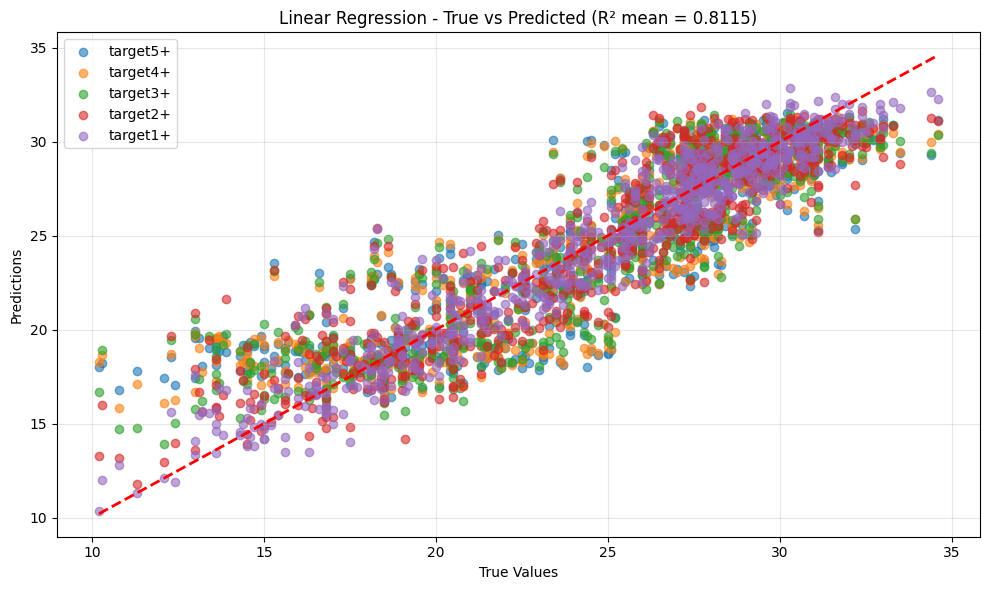

In [32]:
result = linear_regression(X_selected, y, plot=True)

In [34]:
def random_forest(
    X, y,
    n_estimators=500,
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=2,
    test_size=0.2,
    random_state=42,
    plot=True,
    verbose=True
):
    """
    Chỉ chạy Random Forest Regressor (hỗ trợ multi-output)
    80% train / 20% test
    In chi tiết + vẽ biểu đồ đẹp
    """
    # === 1. Chuẩn hóa y ===
    if isinstance(y, (pd.Series, np.ndarray)):
        y_df = pd.DataFrame(y)
    else:
        y_df = y.copy()
    
    if y_df.shape[1] == 1:
        y_df.columns = ['target']
    else:
        y_df.columns = [f"target_{i}" if col.startswith('Unnamed') else col 
                       for i, col in enumerate(y_df.columns)]
    
    target_names = y_df.columns.tolist()
    n_targets = len(target_names)
    
    if verbose:
        print(f"RANDOM FOREST REGRESSOR")
        print(f"Targets ({n_targets}): {target_names}")
        print(f"Data: {X.shape[0]:,} samples × {X.shape[1]:,} features")
        print(f"Model: n_estimators={n_estimators}, max_depth={max_depth or 'None'}")
        print("="*90)

    # === 2. Chia train/test ===
    split_idx = int(len(X) * (1 - test_size))
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]
    
    if verbose:
        print(f"Train: {len(X_train):,} | Test: {len(X_test):,}")

    # === 3. Train Random Forest (native multi-output) ===
    rf = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=random_state,
        n_jobs=-1,
        warm_start=False
    )
    
    if n_targets == 1:
        rf.fit(X_train, y_train.iloc[:, 0])
        y_pred = rf.predict(X_test).reshape(-1, 1)
    else:
        rf.fit(X_train, y_train.values)  # RandomForest hỗ trợ native multi-output
        y_pred = rf.predict(X_test)

    # === 4. Tính metrics ===
    r2_list = [r2_score(y_test.iloc[:, i], y_pred[:, i]) for i in range(n_targets)]
    mae_list = [mean_absolute_error(y_test.iloc[:, i], y_pred[:, i]) for i in range(n_targets)]
    rmse_list = [np.sqrt(mean_squared_error(y_test.iloc[:, i], y_pred[:, i])) for i in range(n_targets)]
    
    r2_mean = np.mean(r2_list)
    mae_mean = np.mean(mae_list)
    rmse_mean = np.mean(rmse_list)

    # === 5. In kết quả đẹp ===
    if verbose:
        print(f"\nRANDOM FOREST RESULTS (Test set - {test_size:.0%})")
        print("-" * 90)
        print(f"{'Target':<18} {'R²':>10} {'MAE':>12} {'RMSE':>12}")
        print("-" * 90)
        for name, r2, mae, rmse in zip(target_names, r2_list, mae_list, rmse_list):
            print(f"{name:<18} {r2:10.4f} {mae:12.4f} {rmse:12.4f}")
        print("-" * 90)
        print(f"{'MEAN':<18} {r2_mean:10.4f} {mae_mean:12.4f} {rmse_mean:12.4f}")
        print("="*90)

    # === 6. Vẽ biểu đồ đẹp ===
    if plot:
        plt.figure(figsize=(12, 5))
        
        # Subplot 1: True vs Predicted
        plt.subplot(1, 2, 1)
        colors = sns.color_palette("husl", n_targets)
        for i in range(n_targets):
            plt.scatter(y_test.iloc[:, i], y_pred[:, i], 
                       alpha=0.6, label=target_names[i], color=colors[i], s=50)
        mins = min(y_test.min().min(), y_pred.min().min())
        maxs = max(y_test.max().max(), y_pred.max().max())
        plt.plot([mins, maxs], [mins, maxs], 'r--', lw=2, label='Perfect')
        plt.xlabel('True Values', fontsize=12)
        plt.ylabel('Predictions', fontsize=12)
        plt.title(f'Random Forest\nMean R² = {r2_mean:.4f}', fontsize=14, fontweight='bold')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # Subplot 2: Residuals
        plt.subplot(1, 2, 2)
        residuals = y_test.values - y_pred
        for i in range(n_targets):
            sns.kdeplot(residuals[:, i], label=target_names[i], fill=True, alpha=0.5)
        plt.xlabel('Residuals')
        plt.ylabel('Density')
        plt.title('Residual Distribution')
        plt.legend()
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    # === 7. Feature Importance (top 15) ===
    if hasattr(rf, 'feature_importances_'):
        importances = rf.feature_importances_
        if n_targets > 1:
            # Trung bình importance qua các cây của tất cả target
            imp_per_tree = np.array([est.feature_importances_ for est in rf.estimators_])
            importances = imp_per_tree.mean(axis=0)
        
        top_idx = np.argsort(importances)[::-1][:15]
        top_features = X.columns[top_idx]
        top_values = importances[top_idx]

        if verbose:
            print(f"\nTOP 15 FEATURES (Gini Importance)")
            print("-" * 50)
            for i, (feat, val) in enumerate(zip(top_features, top_values), 1):
                print(f"{i:2d}. {feat:<30} {val:.5f}")
            print()

        # Vẽ feature importance
        if plot:
            plt.figure(figsize=(10, 6))
            sns.barplot(x=top_values, y=top_features, palette="viridis")
            plt.title("Top 15 Feature Importances (Random Forest)")
            plt.xlabel("Importance")
            plt.tight_layout()
            plt.show()

    # === 8. Trả về ===
    return {
        'model': rf,
        'X_test': X_test,
        'y_test': y_test,
        'y_pred': pd.DataFrame(y_pred, columns=target_names, index=y_test.index),
        'metrics': {
            'R2_per_target': dict(zip(target_names, r2_list)),
            'MAE_per_target': dict(zip(target_names, mae_list)),
            'RMSE_per_target': dict(zip(target_names, rmse_list)),
            'R2_mean': r2_mean,
            'MAE_mean': mae_mean,
            'RMSE_mean': rmse_mean
        },
        'feature_importance': pd.Series(importances, index=X.columns).sort_values(ascending=False),
        'target_names': target_names
    }

RANDOM FOREST REGRESSOR
Targets (5): ['target5+', 'target4+', 'target3+', 'target2+', 'target1+']
Data: 3,635 samples × 100 features
Model: n_estimators=500, max_depth=None
Train: 2,908 | Test: 727

RANDOM FOREST RESULTS (Test set - 20%)
------------------------------------------------------------------------------------------
Target                     R²          MAE         RMSE
------------------------------------------------------------------------------------------
target5+               0.7592       2.0031       2.4910
target4+               0.7704       1.9603       2.4341
target3+               0.7888       1.8699       2.3362
target2+               0.8287       1.6583       2.1049
target1+               0.9016       1.2552       1.5960
------------------------------------------------------------------------------------------
MEAN                   0.8098       1.7494       2.1925


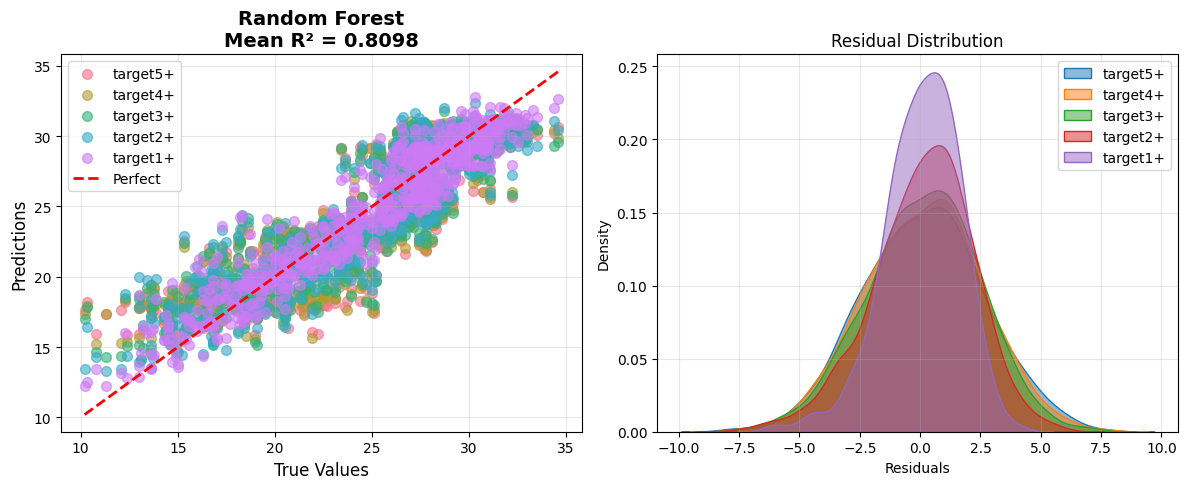


TOP 15 FEATURES (Gini Importance)
--------------------------------------------------
 1. dayofyear_cos_lag_14           0.63311
 2. month_avg_tempmin              0.04235
 3. dayofyear_cos_lag_10           0.04072
 4. temp_sealevelpressure_interaction 0.02494
 5. season_avg_dayofyear_cos       0.02275
 6. season_avg_solarradiation      0.01612
 7. season_avg_solarenergy         0.01056
 8. temp_anomaly_vs_season_avg     0.00973
 9. temp                           0.00875
10. day_avg_temp                   0.00743
11. season_avg_day_length_hours    0.00734
12. tempmax                        0.00648
13. season_avg_sealevelpressure    0.00473
14. temp_anomaly_vs_month_avg      0.00434
15. tempmin                        0.00395



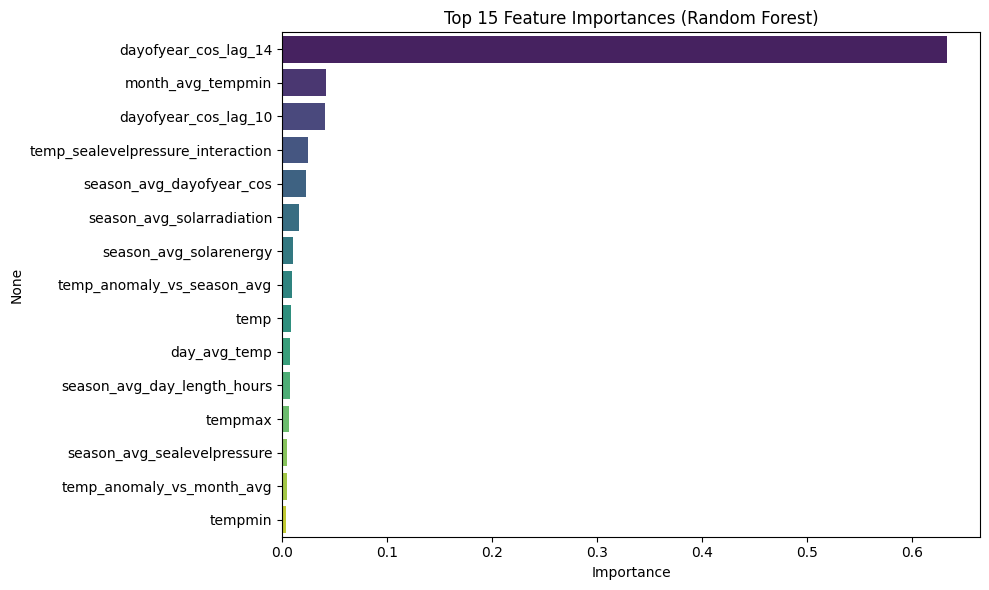

In [36]:
result = random_forest(X_selected, y, n_estimators=500, plot=True)